<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Viz" data-toc-modified-id="Viz-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Viz</a></span></li><li><span><a href="#Solving-just-one-instance-to-check-if-it-works-properly" data-toc-modified-id="Solving-just-one-instance-to-check-if-it-works-properly-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Solving just one instance to check if it works properly</a></span></li><li><span><a href="#Sampling-solutions" data-toc-modified-id="Sampling-solutions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sampling solutions</a></span><ul class="toc-item"><li><span><a href="#Original-graph-without-correction" data-toc-modified-id="Original-graph-without-correction-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Original graph without correction</a></span></li></ul></li></ul></li><li><span><a href="#Analyzing-the-above-points-where-the-ratio-is-super-high" data-toc-modified-id="Analyzing-the-above-points-where-the-ratio-is-super-high-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyzing the above points where the ratio is super high</a></span><ul class="toc-item"><li><span><a href="#Analytical-representation-of-the-bound" data-toc-modified-id="Analytical-representation-of-the-bound-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analytical representation of the bound</a></span></li></ul></li><li><span><a href="#Testing-the-theoretical-bound." data-toc-modified-id="Testing-the-theoretical-bound.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the theoretical bound.</a></span><ul class="toc-item"><li><span><a href="#Linear-case" data-toc-modified-id="Linear-case-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear case</a></span></li></ul></li><li><span><a href="#Testing-if-we-have-indeed-PWA-solution" data-toc-modified-id="Testing-if-we-have-indeed-PWA-solution-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing if we have indeed PWA solution</a></span><ul class="toc-item"><li><span><a href="#Analytical-representation-of-the-bound" data-toc-modified-id="Analytical-representation-of-the-bound-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Analytical representation of the bound</a></span></li></ul></li></ul></div>

In [1]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size = 12)
rc('xtick', labelsize = 12)
rc('ytick', labelsize = 12)
rc('figure', figsize = (8, 4))

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from amod_ed.contractivity_v3 import viz_costs, _construct_problem
from amod_ed.contractivity_v3 import sample_solutions, run_algorithm
import cvxpy as cp
import networkx as nx

import pandas as pd

from amod_ed.contractivity_v3 import plot_results_run, compute_error_KKT, get_d_values

from amod_ed.contractivity_v3 import get_new_r, get_edge_flow, get_flow_edge_od

# Description

We saw that for even 2 nodes we have such cases where the contractivity ratio is very close to 1. 
How can we actually explain that? 

# Load

The characteristics of the graph are loaded from Excel files. 

In [3]:
edges = pd.read_excel('cost_edges_2.xlsx')
inv_edges = pd.read_excel('inv_demand_2.xlsx')

In [4]:
edges

,origin,destination,phi,k
0,1,2,1,3
1,2,1,1,3


In [5]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,1,1,5
1,2,1,1,3,5


## Viz

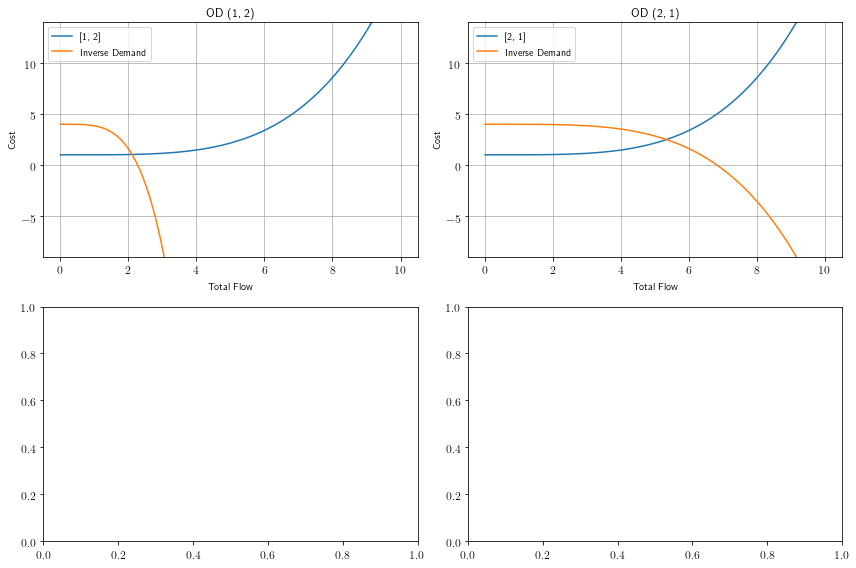

In [6]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 4)

## Solving just one instance to check if it works properly

The below builds the optimization problem. 

In [7]:
correct = False

In [8]:
"""
Returns
-------
f_p: cvxpy.Variable
    The flow for each commodity on each edge
f_r: cvxpy.Variable
    The rebalancing flow on each edge
r: cvxpy.Parameter
    The rebalancing guess for each node
d_var: cvxpy.Variable
    The demand for each each
prob: cvxpy.Problem
    The optimization problem
map_comps: dict
    A map linking components of f_p to the edges and inv edges
map_edges: dict
    A map linking edges to components of f_p
costs_dict: dict
    Dict containing the cost for each edge
inv_demand_dict: dict
    The inverse demand cost for each od pair
G: nx.DiGraph
    Graph representing the network
nodes: list
    list of nodes
"""
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct)

Specify a value of the rebalancing parameter

In [9]:
r_new = [0, 0]
r.value = r_new

You can then solve the problem. 

In [10]:
prob.solve(solver = cp.GUROBI)

Academic license - for non-commercial use only


-17.863447052291708

Check the status. 

In [11]:
prob.status

'optimal'

Therefore, the below function helps in analyzing and decomposing edge by edge for the passenger flow. 

In [12]:
get_edge_flow(f_p, map_edges)

{(1, 2): 2.108266320639359, (2, 1): 5.334422713679979}

In [13]:
get_d_values(inv_edges, d_var)

{(1, 2): 2.108266313817834, (2, 1): 5.334422710855936}

In [14]:
get_flow_edge_od(map_comps, f_p)

{(1, 2): {(1, 2): 2.108266313817834, (2, 1): 6.821525277460575e-09},
 (2, 1): {(1, 2): 2.8240432353655114e-09, (2, 1): 5.334422710855936}}

In [15]:
kkt_rel_error = compute_error_KKT(G, costs_dict, inv_d_dict, inv_edges, map_comps, f_p)

In [35]:
kkt_rel_error

{(1, 2): [1.0000047734475468], (2, 1): [0.9996262538588432]}

We can also compute directly the new rebalancing guess. 

In [36]:
get_new_r(f_p, map_edges, nodes)

[3.22615639304062, -3.22615639304062]

## Sampling solutions

### Original graph without correction

Encountered the eq_dual error


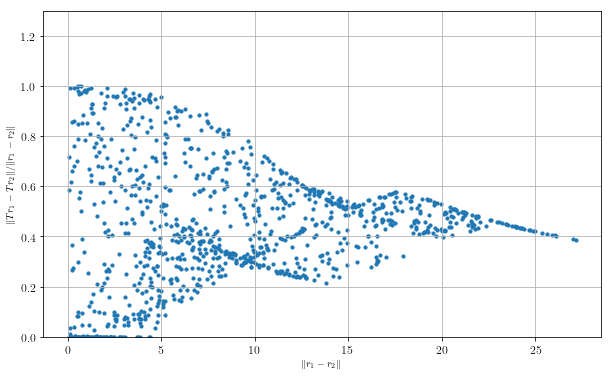

In [16]:
Tr, r_, dT, dr = sample_solutions(edges, inv_edges, nsamples = 1000, \
                                  seed=5, name = 'contractivity_1', save = False)

In [17]:
lim_rat = 0.95

In [19]:
rat = np.divide(dT, dr)

In [28]:
index_high = np.where(rat>lim_rat)[0]

In [21]:
rat[8]

0.9880708261456694

# Analyzing the above points where the ratio is super high

In [54]:
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct)

Specify a value of the rebalancing parameter

In [93]:
idx = index_high[10]

In [80]:
for ii in [idx, idx+1]:

    r_new = r_[ii]
    r.value = r_new

    prob.solve(solver = cp.GUROBI)
    kkt_rel_error = compute_error_KKT(G, costs_dict, inv_d_dict, inv_edges, map_comps, f_p)


    print('old r: ', r_[ii])
    print('edge flow: ', get_edge_flow(f_p, map_edges))
    print('reb flow: ', f_r.value)
    print('new r: ', get_new_r(f_p, map_edges, nodes))
    print("rel kkt error: ", kkt_rel_error)
    print("    ###")
print("---------------------")
print('ratio: ', rat[idx])

old r:  [-4.0639899684755605, 4.0639899684755605]
edge flow:  {(1, 2): 2.1082655078727144, (2, 1): 2.2537449871503843}
reb flow:  [9.20095720e-09 4.06398998e+00]
new r:  [0.1454794792776699, -0.1454794792776699]
rel kkt error:  {(1, 2): [1.0000001076962286], (2, 1): [0.9994889910944461]}
    ###
old r:  [-6.245575426774968, 6.245575426774968]
edge flow:  {(1, 2): 2.108326818007502, (2, 1): 0.09824535119589788}
reb flow:  [7.12763308e-10 6.24557543e+00]
new r:  [-2.0100814668116045, 2.0100814668116045]
rel kkt error:  {(1, 2): [1.0003371091035633], (2, 1): [0.9998076968545057]}
    ###
---------------------
ratio:  0.9880708261456694


## Analytical representation of the bound

In [107]:
v_ = np.linspace(-10, 10, 100)

In [108]:
f1 = []
f2 = []
for v in v_:

    r_new = [v, -v]
    r.value = r_new

    prob.solve(solver = cp.GUROBI)
    f1.append(get_edge_flow(f_p, map_edges)[(1,2)])
    f2.append(get_edge_flow(f_p, map_edges)[(2,1)])


(0, 7)

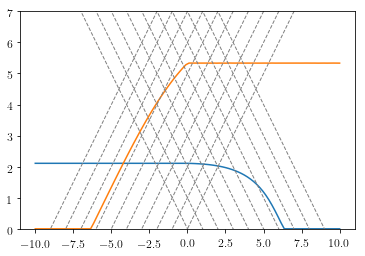

In [116]:
plt.plot(v_, f1)
plt.plot(v_, f2)
for i in np.arange(0, 10):
    plt.plot(v_, v_+i, '--', linewidth = 1, color = 'grey')
    plt.plot(v_, -v_+i, '--', linewidth = 1, color = 'grey')
plt.ylim([0, 7])

# Testing the theoretical bound. 

We have shown that if $\beta, \gamma$ limit the value of the slope of the inverse demand and cost functions, then we have that
$$
|\dot{f}_{i,j}| \leq 1- \frac{\beta}{\gamma+\beta}
$$

We will try to validate that experimentally here, with linear costs. 

In the current setup, we have that the cost functions are implemented as: 

$$
BPR(x,\kappa, \phi) = \phi(1+\alpha (x/\kappa)^\epsilon),
$$

if $\epsilon =1$ (i.e. the cost function is linear), we then have: $\gamma = \phi\alpha/\kappa$. 

Similarly, the inverse demand functions are written as: 

$$
D^{-1} = - BPR() + S,
$$

Again, if $\epsilon = 1$, we have that $\beta = \phi\alpha/\kappa$. 

## Linear case

The default value for alpha is 0.15 .

In [38]:
alpha = 0.15

Let us transform the values in the excels such that the capacities are always 1

In [63]:
k = 1

In [64]:
edges['k'] = k
inv_edges['k'] = k

Let us also choose values for $\beta, \gamma$: 

In [78]:
beta = 2
gamma = 1

In this case, the maximum value of the contractivity ratio should be

In [79]:
1-beta/(gamma+beta)

0.33333333333333337

The values for $\phi$ are: 

In [80]:
phi_p = gamma*k/alpha
phi_inv = beta*k/alpha

In [81]:
edges['phi'] = phi_p
inv_edges['phi'] = phi_inv

In [82]:
inv_edges['shift'] = 50

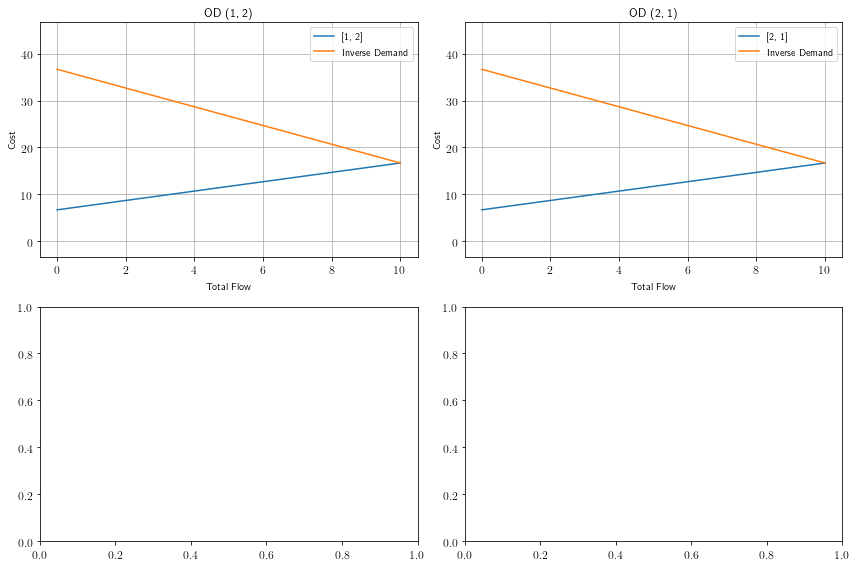

In [83]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)



We see that for the linear case, the relationship holds exactly. 

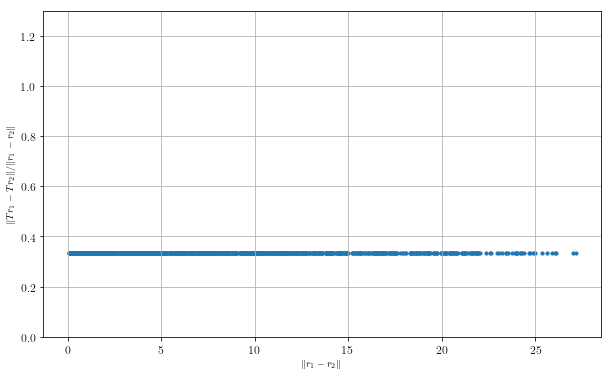

In [84]:
Tr, r_, dT, dr = sample_solutions(edges, inv_edges, nsamples = 1000, \
                                  seed=5, name = 'contractivity_1', save = False, beta = 1)

# Testing if we have indeed PWA solution

In [10]:
edges['phi'] = 3

In [8]:
inv_edges

,origin,destination,phi,k,shift
0,1,2,1,1,5
1,2,1,1,3,5


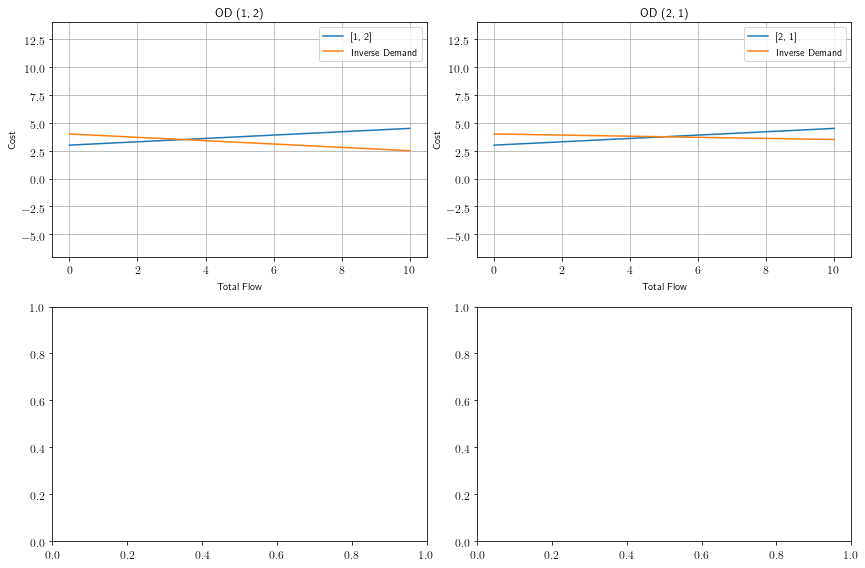

In [11]:
viz_costs(edges, inv_edges, name = 'costs1', save = False, correct = False, beta = 1)



## Analytical representation of the bound

In [14]:
correct = False

In [15]:
f_p, f_r, r, d_var, prob, map_comps, map_edges,\
 costs_dict, inv_d_dict, G, nodes = _construct_problem(edges, inv_edges, correct = correct, beta = 1)

In [16]:
v_ = np.linspace(-10, 10, 100)

In [21]:
f1 = []
f2 = []
f1_r = []
f2_r = []
for v in v_:

    r_new = [v, -v]
    r.value = r_new

    prob.solve(solver = cp.GUROBI)
    f1.append(get_edge_flow(f_p, map_edges)[(1,2)])
    f2.append(get_edge_flow(f_p, map_edges)[(2,1)])
    f1_r.append(f_r.value[0])
    f2_r.append(f_r.value[1])

(0, 7)

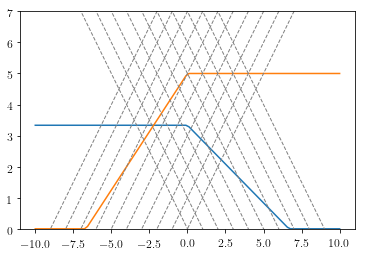

In [18]:
plt.plot(v_, f1)
plt.plot(v_, f2)
for i in np.arange(0, 10):
    plt.plot(v_, v_+i, '--', linewidth = 1, color = 'grey')
    plt.plot(v_, -v_+i, '--', linewidth = 1, color = 'grey')
plt.ylim([0, 7])

Text(0, 0.5, 'f')

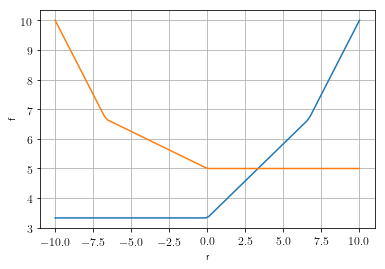

In [24]:
plt.plot(v_, np.array(f1)+np.array(f1_r))
plt.plot(v_, np.array(f2)+np.array(f2_r))
plt.xlabel("r")
plt.grid()
plt.ylabel("f")